# TME 2-4  : Séléction de publicité

## Parsage des données

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import IPython.display as disp
%matplotlib inline

filepath = "CTR.txt"
with open(filepath, 'r') as f:
    data = f.read()

all_articles_id = []
contexts = []
probas = []

for line in data.split('\n'):
    if ':' in line:
        [art_id, ctx, proba] = line.split(':')
        all_articles_id.append(int(art_id))
        contexts.append([float(s) for s in ctx.split(';')])
        probas.append([float(s) for s in proba.split(';')])

contexts = np.array(contexts)
probas   = np.array(probas)


article_ids = all_articles_id[:100]
n_articles = len(article_ids)
n_advertisers = probas.shape[1]

np.set_printoptions(precision=3)
print("Contexts:")
print(contexts[:5])

print("Probas:")
print(probas[:5])
print("Best ads:")
print(np.argmax(probas[:5], axis=1))

Contexts:
[[ 0.748  0.835  0.077  0.172  0.143]
 [ 0.168  0.134  0.435  0.996  0.049]
 [ 0.485  0.567  0.042  0.963  0.185]
 [ 0.622  0.196  0.131  0.44   0.299]
 [ 0.332  0.086  0.023  0.926  0.334]]
Probas:
[[ 0.103  0.191  0.     0.102  0.036  0.075  0.235  0.     0.     0.079]
 [ 0.     0.     0.     0.021  0.     0.     0.023  0.     0.147  0.325]
 [ 0.11   0.137  0.     0.098  0.075  0.     0.     0.     0.015  0.194]
 [ 0.     0.151  0.     0.127  0.112  0.     0.012  0.034  0.     0.086]
 [ 0.     0.109  0.     0.152  0.05   0.     0.     0.037  0.119  0.217]]
Best ads:
[6 9 9 1 9]


## Baseline : Random

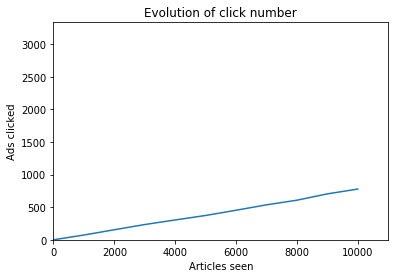

778 clicks, click rate: 0.077800


In [4]:
do_plot = True
def plot_clicks(n_visits, x_values, y_values, ylim=None):
    disp.clear_output(wait=True)
    plt.plot(x_values, y_values)
    plt.title("Evolution of click number")
    plt.xlabel("Articles seen")
    plt.ylabel("Ads clicked")
    plt.xlim(0, n_visits*1.1)
    if ylim is None:
        plt.ylim(0, n_visits/3)
    else:
        plt.ylim(0, ylim)
    plt.show()

def plot_rate(n_visits, x_values, y_values, ylim=None):
    disp.clear_output(wait=True)
    plt.plot(x_values, y_values)
    plt.title("Evolution of click rate")
    plt.xlabel("Articles seen")
    plt.ylabel("Click rate")
    plt.xlim(0, n_visits*1.1)
    if ylim is None:
        plt.ylim(0, 1)
    else:
        plt.ylim(0, ylim)
    plt.show()

n_visits = int(1e4)
n_clicks = 0
x_values = []
y_values = []
for it in range(n_visits):
    article = np.random.choice(article_ids)
    advertiser = np.random.choice(probas[article])
    if np.random.rand() < advertiser:
        n_clicks += 1
    if (it+1)%1000 in (0,1):
        x_values.append(it)
        y_values.append(n_clicks)
        plot_clicks(n_visits, x_values, y_values)
print("%d clicks, click rate: %f" % (n_clicks, n_clicks/n_visits))

## Baseline : Static best

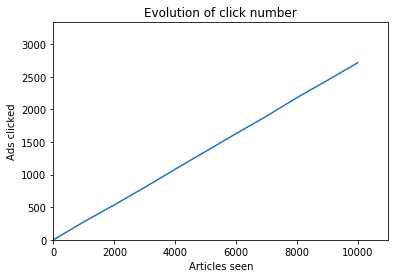

2715 clicks, click rate: 0.271500


In [5]:
n_visits = int(1e4)

agg_clickrate = np.mean(probas, axis=0)
best_rate = max(agg_clickrate)

n_clicks = 0
x_values = []
y_values = []

for it in range(n_visits):
    article = np.random.choice(article_ids)
    if np.random.rand() < best_rate:
        n_clicks += 1
    if (it+1)%1000 in (0,1):
        x_values.append(it)
        y_values.append(n_clicks)
        plot_clicks(n_visits, x_values, y_values)

baserate_staticbest = n_clicks/n_visits
print("%d clicks, click rate: %f" % (n_clicks, n_clicks/n_visits))

## Baseline : Optimal

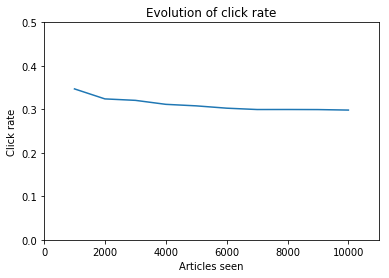

2983 clicks, click rate: 0.298300


In [6]:
n_visits = int(1e4)

n_clicks = 0
x_values = []
y_values = []

for it in range(n_visits):
    article = np.random.choice(article_ids)
    if np.random.rand() < max(probas[article]):
        n_clicks += 1
    if (it+1)%1000 == 0:
        x_values.append(it)
        y_values.append(n_clicks/(it+1))
        plot_rate(n_visits, x_values, y_values, ylim=0.5)

baserate_optimal = n_clicks/n_visits
print("%d clicks, click rate: %f" % (n_clicks, n_clicks/n_visits))

## UCB

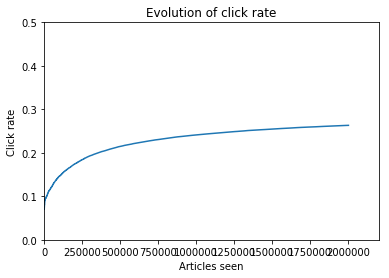

526361 clicks, click rate: 0.263180


In [7]:
trials    = np.zeros_like(probas)
successes = np.zeros_like(probas)

unknown_proba = 1
ads_by_article = {}

n_visits = int(2e6)
n_clicks = 0
x_values = []
y_values = []


for it in range(1, n_visits+1):
    article = np.random.choice(article_ids)
    probas_estim = successes/trials
    probas_estim[np.isinf(probas_estim)] = unknown_proba
    chosen_ad = np.argmax(probas_estim[article] \
                          + np.sqrt(2*np.log(it)/trials[article]))
    trials[article, chosen_ad] += 1
    if article in ads_by_article:
        ads_by_article[article].append(chosen_ad)
    else:
        ads_by_article[article] = [chosen_ad]
    if np.random.rand() < probas[article, chosen_ad]:
        n_clicks += 1
        successes[article, chosen_ad] +=1
    if (it+1)%1000 in (0,1):
        x_values.append(it)
        y_values.append(n_clicks/it)
        plot_rate(n_visits, x_values, y_values, ylim=0.5)

print("%d clicks, click rate: %f" % (n_clicks, n_clicks/n_visits))


In [8]:
for art_id, ads_presented in ads_by_article.items():
    print("Article #%d" % art_id)
    print(ads_presented[:100], "...", ads_presented[-100:])

Article #0
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 9, 1, 2, 3, 4, 5, 6, 7, 8, 0, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 1, 3, 6, 9, 0, 3, 2, 4, 5, 7, 8, 1, 6, 9, 0, 3, 2, 4, 5, 7, 8, 1, 6, 9, 0, 1, 3, 3, 6, 9, 2, 4, 5, 7, 8, 0, 1, 3, 0, 1, 0, 1, 3, 6, 9, 2, 4, 5, 7, 8, 0, 1, 3, 3, 6, 9, 2, 4, 5, 7, 8, 3, 0, 1, 1, 6, 9, 2, 4] ... [6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 3, 1, 1, 1, 1, 1, 6, 0, 6, 6, 1, 6, 9, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 6, 1, 3, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 2, 7, 8, 1, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]
Article #1
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 9, 8, 0, 1, 2, 3, 4, 5, 6, 7, 9, 8] ... [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 

## Linear UCB


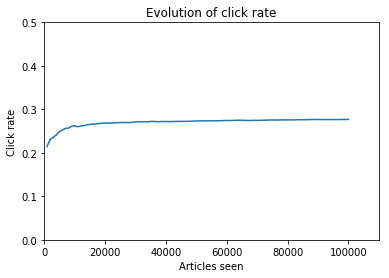

In [33]:
from numpy.linalg import inv

n_visits = int(1e5)
n_clicks = 0
x_values = []
y_values = []
ads_by_article = {}

verbose = False
if verbose:
    n_visits = 100
alpha = 1
A_matrixes = {}
b_vectors = {}
thetas = {}
for it in range(1, n_visits+1):
    article = np.random.choice(article_ids)
    if verbose:
        print("Random article: ", article)
    p = np.zeros(n_advertisers)
    for ad_id in range(n_advertisers):
        #if verbose:
            #print("ad:", ad_id)
        if ad_id not in A_matrixes:
            A_matrixes[ad_id] = np.identity(contexts.shape[1])
            b_vectors[ad_id] = np.zeros_like(contexts[0])
        thetas[ad_id] = inv(A_matrixes[ad_id]).dot(b_vectors[ad_id])
        x = contexts[article]
        p[ad_id] = thetas[ad_id].dot(x) \
            + alpha * np.sqrt(x.dot(inv(A_matrixes[ad_id]).dot(x)))
    chosen_ad = np.argmax(p)
    A_matrixes[chosen_ad] += np.outer(x, x)
    if verbose:
        print("p:", p)
        print("chosen ad:", chosen_ad)
    if article in ads_by_article:
        ads_by_article[article].append(chosen_ad)
    else:
        ads_by_article[article] = [chosen_ad]
    if np.random.rand() < probas[article, chosen_ad]:
        n_clicks += 1
        b_vectors[chosen_ad] += x
    if not verbose and (it+1)%1000 in (0,1):
        x_values.append(it)
        y_values.append(n_clicks/it)
        plot_rate(n_visits, x_values, y_values, ylim=0.5)